# Predvidjanje potrosnje goriva

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


# Preprocesiranje podatak

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 6us/step


'/home/andrija/.keras/datasets/auto-mpg.data'

In [83]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

In [84]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [85]:
dataset = dataset.dropna()

In [86]:
print(dataset['Origin'].unique())

[1 3 2]


In [87]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [88]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
0            70       0      0    1  
1            70       0      0    1  
2            70       0      0    1  
3            70       0      0    1  
4            70       0      0    1  
..          ...     ...    ...  ...  
393          82       0      0    1  
394          82       1      0    0  
395          82       0      0    1  
396          82       0      0    1  
397          82       0      0    1  

[392 rows x 10 columns]

In [89]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

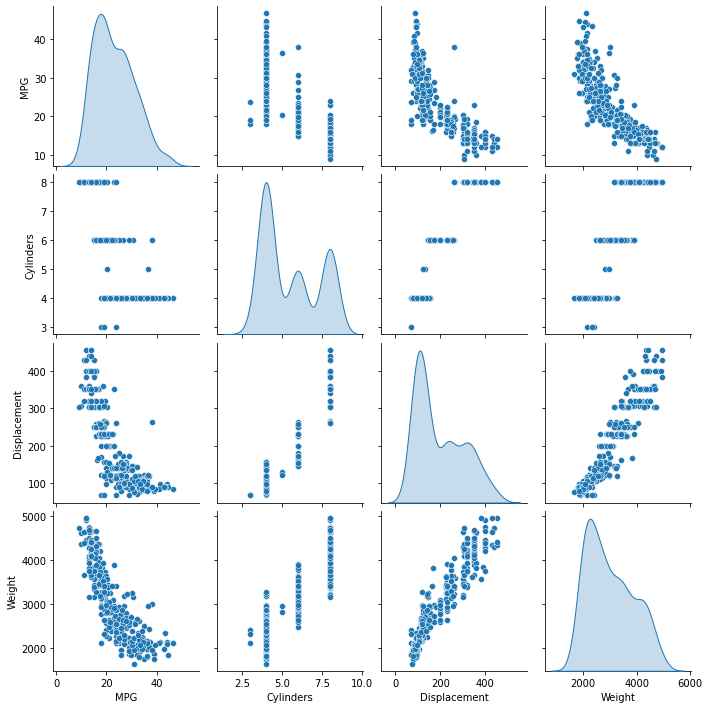

In [90]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [91]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

count         mean         std     min       25%     50%  \
Cylinders     314.0     5.531847    1.729449     3.0     4.000     4.0   
Displacement  314.0   197.855096  106.501896    68.0   105.000   151.0   
Horsepower    314.0   105.971338   39.636557    46.0    76.000    95.0   
Weight        314.0  3005.745223  859.060925  1649.0  2231.000  2831.5   
Acceleration  314.0    15.510828    2.803560     8.0    13.625    15.5   
Model Year    314.0    75.910828    3.688989    70.0    73.000    76.0   
Europe        314.0     0.171975    0.377961     0.0     0.000     0.0   
Japan         314.0     0.203822    0.403481     0.0     0.000     0.0   
USA           314.0     0.624204    0.485101     0.0     0.000     1.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   302.00   455.0  
Horsepower     130.00   230.0  
Weight        3641.75  4955.0  
Acceleration    17.00    24.8  
Model Year      79.00    82.0  
Europe           0.00     1.0  
Japan            0.00     1.0  
USA              1.00     1.0

In [92]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [93]:
train_labels

79     26.0
276    21.6
248    36.1
56     26.0
393    27.0
       ... 
218    36.0
281    19.8
342    30.0
238    33.5
209    19.0
Name: MPG, Length: 314, dtype: float64

In [94]:
test_labels

1      15.0
13     14.0
20     25.0
21     24.0
35     17.0
       ... 
381    36.0
388    26.0
391    36.0
395    32.0
397    31.0
Name: MPG, Length: 78, dtype: float64

In [95]:
train_dataset

Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
79           4          96.0        69.0  2189.0          18.0          72   
276          4         121.0       115.0  2795.0          15.7          78   
248          4          91.0        60.0  1800.0          16.4          78   
56           4          91.0        70.0  1955.0          20.5          71   
393          4         140.0        86.0  2790.0          15.6          82   
..         ...           ...         ...     ...           ...         ...   
218          4          79.0        58.0  1825.0          18.6          77   
281          6         200.0        85.0  2990.0          18.2          79   
342          4         135.0        84.0  2385.0          12.9          81   
238          4          98.0        83.0  2075.0          15.9          77   
209          4         120.0        88.0  3270.0          21.9          76   

     Europe  Japan  USA  
79        1      0    0  
276       1      0    0  
248       0      1    0  
56        0      0    1  
393       0      0    1  
..      ...    ...  ...  
218       1      0    0  
281       0      0    1  
342       0      0    1  
238       0      0    1  
209       1      0    0  

[314 rows x 9 columns]

In [96]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
print(normed_train_data.keys())

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')


# Pravljenje modela

In [97]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['mae', 'mse']
    )
    
    return model

In [98]:
model = build_model()

In [99]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [100]:
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.12175357],
       [0.11681122],
       [0.32438126],
       [0.33316812],
       [0.19789433],
       [0.2910559 ],
       [0.15510127],
       [0.28209186],
       [0.40686026],
       [0.21189764]], dtype=float32)

In [101]:
example_result.shape

(10, 1)

In [102]:
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=1
)


Epoch 1/1000
8/8 [==============================] - 1s 23ms/step - loss: 591.1503 - mae: 23.0257 - mse: 591.1503 - val_loss: 514.2752 - val_mae: 21.3354 - val_mse: 514.2752
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 549.5697 - mae: 22.1720 - mse: 549.5697 - val_loss: 476.3768 - val_mae: 20.4927 - val_mse: 476.3768
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 505.9398 - mae: 21.2263 - mse: 505.9398 - val_loss: 433.8302 - val_mae: 19.5070 - val_mse: 433.8302
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 453.0014 - mae: 20.0539 - mse: 453.0014 - val_loss: 384.5668 - val_mae: 18.3030 - val_mse: 384.5668
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 393.6305 - mae: 18.6152 - mse: 393.6305 - val_loss: 325.8295 - val_mae: 16.7724 - val_mse: 325.8295
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 321.0314 - mae: 16.7354 - mse: 321.0314 - val_loss: 259.4028 - val_

8/8 [==============================] - 0s 5ms/step - loss: 8.1523 - mae: 2.0611 - mse: 8.1523 - val_loss: 7.5068 - val_mae: 2.0428 - val_mse: 7.5068
Epoch 51/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.0842 - mae: 2.0503 - mse: 8.0842 - val_loss: 7.5216 - val_mae: 2.0280 - val_mse: 7.5216
Epoch 52/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.0395 - mae: 2.0469 - mse: 8.0395 - val_loss: 7.4498 - val_mae: 2.0129 - val_mse: 7.4498
Epoch 53/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.0281 - mae: 2.0440 - mse: 8.0281 - val_loss: 7.3686 - val_mae: 2.0169 - val_mse: 7.3686
Epoch 54/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.9727 - mae: 2.0385 - mse: 7.9727 - val_loss: 7.2873 - val_mae: 2.0030 - val_mse: 7.2873
Epoch 55/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.9549 - mae: 2.0383 - mse: 7.9549 - val_loss: 7.2408 - val_mae: 2.0032 - val_mse: 7.2408
Epoch 56/1000
8/8 [=================

8/8 [==============================] - 0s 5ms/step - loss: 7.0464 - mae: 1.9013 - mse: 7.0464 - val_loss: 6.1651 - val_mae: 1.8895 - val_mse: 6.1651
Epoch 101/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0021 - mae: 1.8900 - mse: 7.0021 - val_loss: 6.2209 - val_mae: 1.8857 - val_mse: 6.2209
Epoch 102/1000
8/8 [==============================] - 0s 6ms/step - loss: 7.0716 - mae: 1.9053 - mse: 7.0716 - val_loss: 6.2452 - val_mae: 1.8737 - val_mse: 6.2452
Epoch 103/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.9807 - mae: 1.8905 - mse: 6.9807 - val_loss: 6.0279 - val_mae: 1.8699 - val_mse: 6.0279
Epoch 104/1000
8/8 [==============================] - 0s 6ms/step - loss: 6.9998 - mae: 1.8917 - mse: 6.9998 - val_loss: 6.0291 - val_mae: 1.8716 - val_mse: 6.0291
Epoch 105/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0160 - mae: 1.8893 - mse: 7.0160 - val_loss: 6.1594 - val_mae: 1.8750 - val_mse: 6.1594
Epoch 106/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 6.5956 - mae: 1.8243 - mse: 6.5956 - val_loss: 5.4635 - val_mae: 1.7960 - val_mse: 5.4635
Epoch 151/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.5092 - mae: 1.8130 - mse: 6.5092 - val_loss: 5.5658 - val_mae: 1.7861 - val_mse: 5.5658
Epoch 152/1000
8/8 [==============================] - 0s 6ms/step - loss: 6.6040 - mae: 1.8193 - mse: 6.6040 - val_loss: 5.5605 - val_mae: 1.7839 - val_mse: 5.5605
Epoch 153/1000
8/8 [==============================] - 0s 6ms/step - loss: 6.5191 - mae: 1.8164 - mse: 6.5191 - val_loss: 5.4268 - val_mae: 1.7757 - val_mse: 5.4268
Epoch 154/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.5350 - mae: 1.8223 - mse: 6.5350 - val_loss: 5.4131 - val_mae: 1.7942 - val_mse: 5.4131
Epoch 155/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.4585 - mae: 1.8115 - mse: 6.4585 - val_loss: 5.5039 - val_mae: 1.7785 - val_mse: 5.5039
Epoch 156/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 6.1294 - mae: 1.7531 - mse: 6.1294 - val_loss: 5.0724 - val_mae: 1.7243 - val_mse: 5.0724
Epoch 201/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1149 - mae: 1.7543 - mse: 6.1149 - val_loss: 5.0574 - val_mae: 1.7264 - val_mse: 5.0574
Epoch 202/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1463 - mae: 1.7614 - mse: 6.1463 - val_loss: 5.0648 - val_mae: 1.7301 - val_mse: 5.0648
Epoch 203/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1390 - mae: 1.7544 - mse: 6.1390 - val_loss: 5.1536 - val_mae: 1.7389 - val_mse: 5.1536
Epoch 204/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1716 - mae: 1.7629 - mse: 6.1716 - val_loss: 5.0528 - val_mae: 1.7192 - val_mse: 5.0528
Epoch 205/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1209 - mae: 1.7600 - mse: 6.1209 - val_loss: 4.9301 - val_mae: 1.7123 - val_mse: 4.9301
Epoch 206/1000
8/8 [===========

8/8 [==============================] - 0s 6ms/step - loss: 5.9164 - mae: 1.7118 - mse: 5.9164 - val_loss: 4.9227 - val_mae: 1.6991 - val_mse: 4.9227
Epoch 251/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.8875 - mae: 1.7131 - mse: 5.8875 - val_loss: 4.8209 - val_mae: 1.6875 - val_mse: 4.8209
Epoch 252/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.8408 - mae: 1.7131 - mse: 5.8408 - val_loss: 4.8686 - val_mae: 1.6882 - val_mse: 4.8686
Epoch 253/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.8968 - mae: 1.7293 - mse: 5.8968 - val_loss: 4.8573 - val_mae: 1.6907 - val_mse: 4.8573
Epoch 254/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.8935 - mae: 1.7202 - mse: 5.8935 - val_loss: 4.8033 - val_mae: 1.6818 - val_mse: 4.8033
Epoch 255/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.9093 - mae: 1.7201 - mse: 5.9093 - val_loss: 4.8064 - val_mae: 1.7076 - val_mse: 4.8064
Epoch 256/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 5.7046 - mae: 1.6832 - mse: 5.7046 - val_loss: 4.8499 - val_mae: 1.6802 - val_mse: 4.8499
Epoch 301/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.6543 - mae: 1.6791 - mse: 5.6543 - val_loss: 4.6938 - val_mae: 1.6742 - val_mse: 4.6938
Epoch 302/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.6902 - mae: 1.6785 - mse: 5.6902 - val_loss: 4.7549 - val_mae: 1.6723 - val_mse: 4.7549
Epoch 303/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.6979 - mae: 1.6782 - mse: 5.6979 - val_loss: 4.7510 - val_mae: 1.6742 - val_mse: 4.7510
Epoch 304/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.6566 - mae: 1.6873 - mse: 5.6566 - val_loss: 4.7475 - val_mae: 1.6979 - val_mse: 4.7475
Epoch 305/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.6473 - mae: 1.6791 - mse: 5.6473 - val_loss: 4.7771 - val_mae: 1.6713 - val_mse: 4.7771
Epoch 306/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 5.5172 - mae: 1.6557 - mse: 5.5172 - val_loss: 4.7986 - val_mae: 1.6916 - val_mse: 4.7986
Epoch 351/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.4757 - mae: 1.6507 - mse: 5.4757 - val_loss: 4.8126 - val_mae: 1.6776 - val_mse: 4.8126
Epoch 352/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.4507 - mae: 1.6426 - mse: 5.4507 - val_loss: 4.7537 - val_mae: 1.6804 - val_mse: 4.7537
Epoch 353/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.5460 - mae: 1.6562 - mse: 5.5460 - val_loss: 4.8151 - val_mae: 1.6777 - val_mse: 4.8151
Epoch 354/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.5339 - mae: 1.6708 - mse: 5.5339 - val_loss: 4.6858 - val_mae: 1.6728 - val_mse: 4.6858
Epoch 355/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.5149 - mae: 1.6644 - mse: 5.5149 - val_loss: 4.9116 - val_mae: 1.6937 - val_mse: 4.9116
Epoch 356/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 5.2518 - mae: 1.6072 - mse: 5.2518 - val_loss: 5.0359 - val_mae: 1.6914 - val_mse: 5.0359
Epoch 401/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.3837 - mae: 1.6229 - mse: 5.3837 - val_loss: 4.8101 - val_mae: 1.6844 - val_mse: 4.8101
Epoch 402/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.2847 - mae: 1.6250 - mse: 5.2847 - val_loss: 4.7087 - val_mae: 1.6756 - val_mse: 4.7087
Epoch 403/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.3093 - mae: 1.6249 - mse: 5.3093 - val_loss: 4.7668 - val_mae: 1.6818 - val_mse: 4.7668
Epoch 404/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.4758 - mae: 1.6409 - mse: 5.4758 - val_loss: 4.7668 - val_mae: 1.6986 - val_mse: 4.7668
Epoch 405/1000
8/8 [==============================] - 0s 6ms/step - loss: 5.4305 - mae: 1.6352 - mse: 5.4305 - val_loss: 4.9759 - val_mae: 1.7078 - val_mse: 4.9759
Epoch 406/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 5.0931 - mae: 1.5675 - mse: 5.0931 - val_loss: 4.7074 - val_mae: 1.6761 - val_mse: 4.7074
Epoch 451/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.0775 - mae: 1.5777 - mse: 5.0775 - val_loss: 4.7435 - val_mae: 1.6846 - val_mse: 4.7435
Epoch 452/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.1696 - mae: 1.5800 - mse: 5.1696 - val_loss: 4.7729 - val_mae: 1.6625 - val_mse: 4.7729
Epoch 453/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.0895 - mae: 1.5810 - mse: 5.0895 - val_loss: 4.7449 - val_mae: 1.6924 - val_mse: 4.7449
Epoch 454/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.0381 - mae: 1.5733 - mse: 5.0381 - val_loss: 4.8822 - val_mae: 1.6896 - val_mse: 4.8822
Epoch 455/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.0133 - mae: 1.5648 - mse: 5.0133 - val_loss: 4.7145 - val_mae: 1.6611 - val_mse: 4.7145
Epoch 456/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 4.8343 - mae: 1.5292 - mse: 4.8343 - val_loss: 4.6926 - val_mae: 1.6755 - val_mse: 4.6926
Epoch 501/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.7276 - mae: 1.5138 - mse: 4.7276 - val_loss: 4.9339 - val_mae: 1.6710 - val_mse: 4.9339
Epoch 502/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.8872 - mae: 1.5390 - mse: 4.8872 - val_loss: 4.6941 - val_mae: 1.6709 - val_mse: 4.6941
Epoch 503/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.7686 - mae: 1.5238 - mse: 4.7686 - val_loss: 4.6565 - val_mae: 1.6479 - val_mse: 4.6565
Epoch 504/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.9024 - mae: 1.5214 - mse: 4.9024 - val_loss: 4.7939 - val_mae: 1.6920 - val_mse: 4.7939
Epoch 505/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.7039 - mae: 1.5024 - mse: 4.7039 - val_loss: 5.0096 - val_mae: 1.6790 - val_mse: 5.0096
Epoch 506/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 4.5301 - mae: 1.4585 - mse: 4.5301 - val_loss: 4.8997 - val_mae: 1.6704 - val_mse: 4.8997
Epoch 551/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.6838 - mae: 1.4998 - mse: 4.6838 - val_loss: 4.5563 - val_mae: 1.6574 - val_mse: 4.5563
Epoch 552/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.6209 - mae: 1.4885 - mse: 4.6209 - val_loss: 4.9274 - val_mae: 1.6492 - val_mse: 4.9274
Epoch 553/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.4878 - mae: 1.4546 - mse: 4.4878 - val_loss: 4.7145 - val_mae: 1.6732 - val_mse: 4.7145
Epoch 554/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.5601 - mae: 1.4706 - mse: 4.5601 - val_loss: 4.8299 - val_mae: 1.6595 - val_mse: 4.8299
Epoch 555/1000
8/8 [==============================] - 0s 4ms/step - loss: 4.4720 - mae: 1.4529 - mse: 4.4720 - val_loss: 4.6041 - val_mae: 1.6324 - val_mse: 4.6041
Epoch 556/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 4.1671 - mae: 1.3909 - mse: 4.1671 - val_loss: 4.7085 - val_mae: 1.6535 - val_mse: 4.7085
Epoch 601/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.2491 - mae: 1.3997 - mse: 4.2491 - val_loss: 4.8400 - val_mae: 1.6744 - val_mse: 4.8400
Epoch 602/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.1909 - mae: 1.3864 - mse: 4.1909 - val_loss: 4.6463 - val_mae: 1.6543 - val_mse: 4.6463
Epoch 603/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.1281 - mae: 1.3810 - mse: 4.1281 - val_loss: 4.8160 - val_mae: 1.6730 - val_mse: 4.8160
Epoch 604/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.3369 - mae: 1.4119 - mse: 4.3369 - val_loss: 4.8912 - val_mae: 1.6523 - val_mse: 4.8912
Epoch 605/1000
8/8 [==============================] - 0s 5ms/step - loss: 4.2490 - mae: 1.4006 - mse: 4.2490 - val_loss: 4.6916 - val_mae: 1.6866 - val_mse: 4.6916
Epoch 606/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 3.8151 - mae: 1.3145 - mse: 3.8151 - val_loss: 4.8848 - val_mae: 1.6610 - val_mse: 4.8848
Epoch 651/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.8085 - mae: 1.3048 - mse: 3.8085 - val_loss: 4.8921 - val_mae: 1.6632 - val_mse: 4.8921
Epoch 652/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.8443 - mae: 1.3211 - mse: 3.8443 - val_loss: 4.8486 - val_mae: 1.6659 - val_mse: 4.8486
Epoch 653/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.8463 - mae: 1.3271 - mse: 3.8463 - val_loss: 4.9615 - val_mae: 1.7126 - val_mse: 4.9615
Epoch 654/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.8116 - mae: 1.3226 - mse: 3.8116 - val_loss: 5.0962 - val_mae: 1.6933 - val_mse: 5.0962
Epoch 655/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.7997 - mae: 1.3056 - mse: 3.7997 - val_loss: 4.8476 - val_mae: 1.6847 - val_mse: 4.8476
Epoch 656/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 3.4733 - mae: 1.2475 - mse: 3.4733 - val_loss: 5.2461 - val_mae: 1.7095 - val_mse: 5.2461
Epoch 701/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.5450 - mae: 1.2555 - mse: 3.5450 - val_loss: 5.0102 - val_mae: 1.6655 - val_mse: 5.0102
Epoch 702/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.4690 - mae: 1.2332 - mse: 3.4690 - val_loss: 5.0809 - val_mae: 1.7199 - val_mse: 5.0809
Epoch 703/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.4736 - mae: 1.2423 - mse: 3.4736 - val_loss: 5.2259 - val_mae: 1.7246 - val_mse: 5.2259
Epoch 704/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.4387 - mae: 1.2367 - mse: 3.4387 - val_loss: 5.0460 - val_mae: 1.6770 - val_mse: 5.0460
Epoch 705/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.5007 - mae: 1.2529 - mse: 3.5007 - val_loss: 5.0871 - val_mae: 1.7211 - val_mse: 5.0871
Epoch 706/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 3.2518 - mae: 1.1927 - mse: 3.2518 - val_loss: 5.3926 - val_mae: 1.7542 - val_mse: 5.3926
Epoch 751/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.2626 - mae: 1.1902 - mse: 3.2626 - val_loss: 5.3663 - val_mae: 1.7515 - val_mse: 5.3663
Epoch 752/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.2342 - mae: 1.1932 - mse: 3.2342 - val_loss: 5.2847 - val_mae: 1.7024 - val_mse: 5.2847
Epoch 753/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.2423 - mae: 1.1936 - mse: 3.2423 - val_loss: 5.3076 - val_mae: 1.7545 - val_mse: 5.3076
Epoch 754/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.2325 - mae: 1.1821 - mse: 3.2325 - val_loss: 5.3948 - val_mae: 1.7581 - val_mse: 5.3948
Epoch 755/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.1815 - mae: 1.1773 - mse: 3.1815 - val_loss: 5.4138 - val_mae: 1.7278 - val_mse: 5.4138
Epoch 756/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 3.0929 - mae: 1.1414 - mse: 3.0929 - val_loss: 5.7246 - val_mae: 1.7957 - val_mse: 5.7246
Epoch 801/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.0358 - mae: 1.1406 - mse: 3.0358 - val_loss: 5.5215 - val_mae: 1.7762 - val_mse: 5.5215
Epoch 802/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.9598 - mae: 1.1223 - mse: 2.9598 - val_loss: 5.5543 - val_mae: 1.7854 - val_mse: 5.5543
Epoch 803/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.9967 - mae: 1.1329 - mse: 2.9967 - val_loss: 5.6334 - val_mae: 1.7876 - val_mse: 5.6334
Epoch 804/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.0371 - mae: 1.1324 - mse: 3.0371 - val_loss: 5.5727 - val_mae: 1.7671 - val_mse: 5.5727
Epoch 805/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.0211 - mae: 1.1436 - mse: 3.0211 - val_loss: 5.5842 - val_mae: 1.7844 - val_mse: 5.5842
Epoch 806/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 2.7802 - mae: 1.0724 - mse: 2.7802 - val_loss: 5.9059 - val_mae: 1.8449 - val_mse: 5.9059
Epoch 851/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.7923 - mae: 1.0766 - mse: 2.7923 - val_loss: 5.9784 - val_mae: 1.8597 - val_mse: 5.9784
Epoch 852/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.7590 - mae: 1.0792 - mse: 2.7590 - val_loss: 6.1170 - val_mae: 1.8645 - val_mse: 6.1170
Epoch 853/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.7266 - mae: 1.0588 - mse: 2.7266 - val_loss: 5.7624 - val_mae: 1.8167 - val_mse: 5.7624
Epoch 854/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.7438 - mae: 1.0705 - mse: 2.7438 - val_loss: 5.9013 - val_mae: 1.8506 - val_mse: 5.9013
Epoch 855/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.7868 - mae: 1.0816 - mse: 2.7868 - val_loss: 5.9958 - val_mae: 1.8602 - val_mse: 5.9958
Epoch 856/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 2.5690 - mae: 1.0172 - mse: 2.5690 - val_loss: 6.1566 - val_mae: 1.8785 - val_mse: 6.1566
Epoch 901/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.6114 - mae: 1.0279 - mse: 2.6114 - val_loss: 6.1934 - val_mae: 1.9050 - val_mse: 6.1934
Epoch 902/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5470 - mae: 1.0320 - mse: 2.5470 - val_loss: 6.2602 - val_mae: 1.9054 - val_mse: 6.2602
Epoch 903/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.6541 - mae: 1.0354 - mse: 2.6541 - val_loss: 5.9804 - val_mae: 1.8599 - val_mse: 5.9804
Epoch 904/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5377 - mae: 1.0039 - mse: 2.5377 - val_loss: 6.2142 - val_mae: 1.9040 - val_mse: 6.2142
Epoch 905/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.5416 - mae: 1.0144 - mse: 2.5416 - val_loss: 6.0640 - val_mae: 1.8654 - val_mse: 6.0640
Epoch 906/1000
8/8 [===========

8/8 [==============================] - 0s 4ms/step - loss: 2.4333 - mae: 0.9774 - mse: 2.4333 - val_loss: 6.3549 - val_mae: 1.8909 - val_mse: 6.3549
Epoch 951/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.4500 - mae: 0.9603 - mse: 2.4500 - val_loss: 6.4581 - val_mae: 1.9429 - val_mse: 6.4581
Epoch 952/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.3664 - mae: 0.9664 - mse: 2.3664 - val_loss: 6.3251 - val_mae: 1.8986 - val_mse: 6.3251
Epoch 953/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.4336 - mae: 0.9696 - mse: 2.4336 - val_loss: 6.3877 - val_mae: 1.9128 - val_mse: 6.3877
Epoch 954/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.3231 - mae: 0.9425 - mse: 2.3231 - val_loss: 6.2184 - val_mae: 1.8949 - val_mse: 6.2184
Epoch 955/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.4916 - mae: 1.0121 - mse: 2.4916 - val_loss: 6.7687 - val_mae: 1.9845 - val_mse: 6.7687
Epoch 956/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 2.3731 - mae: 0.9515 - mse: 2.3731 - val_loss: 6.4011 - val_mae: 1.9502 - val_mse: 6.4011


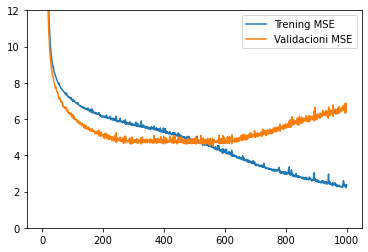

In [103]:
plt.plot(history.epoch, history.history['mse'])
plt.plot(history.epoch, history.history['val_mse'])
plt.ylim([0, 12])
plt.legend(['Trening MSE', 'Validacioni MSE'])

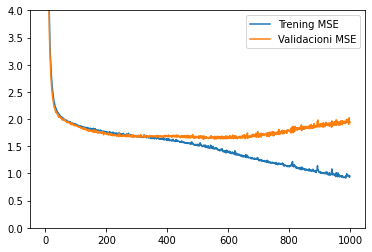

In [104]:
plt.plot(history.epoch, history.history['mae'])
plt.plot(history.epoch, history.history['val_mae'])
plt.ylim([0,4])
plt.legend(['Trening MSE', 'Validacioni MSE'])

In [105]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

hist

loss        mae         mse    val_loss    val_mae     val_mse  \
0    591.150330  23.025742  591.150330  514.275208  21.335442  514.275208   
1    549.569702  22.172024  549.569702  476.376831  20.492725  476.376831   
2    505.939789  21.226282  505.939789  433.830231  19.506960  433.830231   
3    453.001373  20.053926  453.001373  384.566803  18.303013  384.566803   
4    393.630524  18.615200  393.630524  325.829529  16.772427  325.829529   
..          ...        ...         ...         ...        ...         ...   
995    2.349035   0.955988    2.349035    6.312355   1.906251    6.312355   
996    2.311516   0.944344    2.311516    6.602344   1.968779    6.602344   
997    2.374014   0.964886    2.374014    6.869921   2.024441    6.869921   
998    2.208737   0.928954    2.208737    6.431741   1.917028    6.431741   
999    2.373135   0.951535    2.373136    6.401070   1.950183    6.401070   

     epoch  
0        0  
1        1  
2        2  
3        3  
4        4  
..     ...  
995    995  
996    996  
997    997  
998    998  
999    999  

[1000 rows x 7 columns]

In [106]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=1,
    callbacks=[early_stop]
)

Epoch 1/1000
8/8 [==============================] - 1s 23ms/step - loss: 598.9782 - mae: 23.1703 - mse: 598.9782 - val_loss: 524.8813 - val_mae: 21.5254 - val_mse: 524.8813
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 564.8541 - mae: 22.4413 - mse: 564.8541 - val_loss: 493.0437 - val_mae: 20.7710 - val_mse: 493.0437
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 526.2305 - mae: 21.5748 - mse: 526.2305 - val_loss: 455.5868 - val_mae: 19.8544 - val_mse: 455.5868
Epoch 4/1000
8/8 [==============================] - 0s 5ms/step - loss: 478.0670 - mae: 20.4853 - mse: 478.0670 - val_loss: 409.4797 - val_mae: 18.6804 - val_mse: 409.4797
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 420.8895 - mae: 19.0887 - mse: 420.8895 - val_loss: 354.9368 - val_mae: 17.2102 - val_mse: 354.9368
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 352.0504 - mae: 17.3172 - mse: 352.0504 - val_loss: 293.8406 - val_

8/8 [==============================] - 0s 5ms/step - loss: 8.5797 - mae: 2.1557 - mse: 8.5797 - val_loss: 8.2878 - val_mae: 2.1185 - val_mse: 8.2878
Epoch 51/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.5326 - mae: 2.1497 - mse: 8.5326 - val_loss: 8.2214 - val_mae: 2.1136 - val_mse: 8.2214
Epoch 52/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.4759 - mae: 2.1381 - mse: 8.4759 - val_loss: 8.1957 - val_mae: 2.0987 - val_mse: 8.1957
Epoch 53/1000
8/8 [==============================] - 0s 4ms/step - loss: 8.4431 - mae: 2.1316 - mse: 8.4431 - val_loss: 8.0650 - val_mae: 2.0905 - val_mse: 8.0650
Epoch 54/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.4104 - mae: 2.1196 - mse: 8.4104 - val_loss: 8.0936 - val_mae: 2.0877 - val_mse: 8.0936
Epoch 55/1000
8/8 [==============================] - 0s 5ms/step - loss: 8.3516 - mae: 2.1169 - mse: 8.3516 - val_loss: 7.9005 - val_mae: 2.0726 - val_mse: 7.9005
Epoch 56/1000
8/8 [=================

8/8 [==============================] - 0s 5ms/step - loss: 7.1683 - mae: 1.9191 - mse: 7.1683 - val_loss: 6.4869 - val_mae: 1.9135 - val_mse: 6.4869
Epoch 101/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0795 - mae: 1.9029 - mse: 7.0795 - val_loss: 6.5012 - val_mae: 1.9103 - val_mse: 6.5012
Epoch 102/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0826 - mae: 1.8967 - mse: 7.0826 - val_loss: 6.5013 - val_mae: 1.9100 - val_mse: 6.5013
Epoch 103/1000
8/8 [==============================] - 0s 4ms/step - loss: 7.0673 - mae: 1.8995 - mse: 7.0673 - val_loss: 6.4545 - val_mae: 1.9012 - val_mse: 6.4545
Epoch 104/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0534 - mae: 1.8997 - mse: 7.0534 - val_loss: 6.3919 - val_mae: 1.8947 - val_mse: 6.3919
Epoch 105/1000
8/8 [==============================] - 0s 5ms/step - loss: 7.0437 - mae: 1.8984 - mse: 7.0437 - val_loss: 6.3565 - val_mae: 1.8912 - val_mse: 6.3565
Epoch 106/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 6.5630 - mae: 1.8154 - mse: 6.5630 - val_loss: 5.6989 - val_mae: 1.7880 - val_mse: 5.6989
Epoch 151/1000
8/8 [==============================] - 0s 4ms/step - loss: 6.5722 - mae: 1.8147 - mse: 6.5722 - val_loss: 5.7004 - val_mae: 1.7895 - val_mse: 5.7004
Epoch 152/1000
8/8 [==============================] - 0s 4ms/step - loss: 6.5810 - mae: 1.8202 - mse: 6.5810 - val_loss: 5.6014 - val_mae: 1.7755 - val_mse: 5.6014
Epoch 153/1000
8/8 [==============================] - 0s 4ms/step - loss: 6.5633 - mae: 1.8129 - mse: 6.5633 - val_loss: 5.6346 - val_mae: 1.7907 - val_mse: 5.6346
Epoch 154/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.5299 - mae: 1.8182 - mse: 6.5299 - val_loss: 5.6798 - val_mae: 1.7898 - val_mse: 5.6798
Epoch 155/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.5559 - mae: 1.8079 - mse: 6.5559 - val_loss: 5.6713 - val_mae: 1.7844 - val_mse: 5.6713
Epoch 156/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 6.2404 - mae: 1.7619 - mse: 6.2404 - val_loss: 5.1972 - val_mae: 1.7272 - val_mse: 5.1972
Epoch 201/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.2208 - mae: 1.7563 - mse: 6.2208 - val_loss: 5.2244 - val_mae: 1.7237 - val_mse: 5.2244
Epoch 202/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.2126 - mae: 1.7558 - mse: 6.2126 - val_loss: 5.2506 - val_mae: 1.7228 - val_mse: 5.2506
Epoch 203/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1839 - mae: 1.7502 - mse: 6.1839 - val_loss: 5.2178 - val_mae: 1.7153 - val_mse: 5.2178
Epoch 204/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.2066 - mae: 1.7571 - mse: 6.2066 - val_loss: 5.1480 - val_mae: 1.6994 - val_mse: 5.1480
Epoch 205/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.2163 - mae: 1.7624 - mse: 6.2163 - val_loss: 5.1199 - val_mae: 1.7023 - val_mse: 5.1199
Epoch 206/1000
8/8 [===========

8/8 [==============================] - 0s 5ms/step - loss: 6.0023 - mae: 1.7231 - mse: 6.0023 - val_loss: 4.8664 - val_mae: 1.6572 - val_mse: 4.8664
Epoch 251/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.9900 - mae: 1.7127 - mse: 5.9900 - val_loss: 4.9645 - val_mae: 1.6630 - val_mse: 4.9645
Epoch 252/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.9764 - mae: 1.7123 - mse: 5.9764 - val_loss: 4.9565 - val_mae: 1.6601 - val_mse: 4.9565
Epoch 253/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.0881 - mae: 1.7225 - mse: 6.0881 - val_loss: 4.8770 - val_mae: 1.6741 - val_mse: 4.8770
Epoch 254/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9505 - mae: 1.7075 - mse: 5.9505 - val_loss: 4.9794 - val_mae: 1.6599 - val_mse: 4.9794
Epoch 255/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.0194 - mae: 1.7216 - mse: 6.0194 - val_loss: 4.9743 - val_mae: 1.6652 - val_mse: 4.9743
Epoch 256/1000
8/8 [===========

Text(0, 0.5, 'MAE [MPG]')

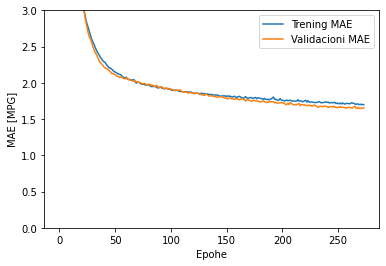

In [112]:
plt.plot(early_history.epoch, early_history.history['mae'])
plt.plot(early_history.epoch, early_history.history['val_mae'])
plt.ylim([0, 3])
plt.legend(['Trening MAE', 'Validacioni MAE'])
plt.xlabel('Epohe')
plt.ylabel('MAE [MPG]')

In [113]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print(f"Testing set MAE: {mae}")

3/3 - 0s - loss: 5.7782 - mae: 1.7394 - mse: 5.7782
Testing set MAE: 1.7393906116485596
